# Introduction

This is my entry point into text generation topic. It is based on this notebook ran in G Colab: https://colab.research.google.com/drive/1Qo-SxNRgmFRDD1OnS584TkF-1pTEwIaD?usp=sharing#scrollTo=kW4W_6E2gvBH

There are no explanations neither clues for a better understanding of the problem. At the end the problem is treated in a kind of time series way by making windows with the words turned into tokens.

Good thing is that I have discovered Gutenberg project, a very usefull tool to download specific text.

First part is developped deleting stopwords while the second one contains these stop words.

![Machine](imgs/text_g.jpg)


In [97]:
!nvidia-smi | grep "Tesla"

|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |


In [2]:
import numpy
import sys
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
!wget https://www.gutenberg.org/cache/epub/17073/pg17073.txt

--2021-08-16 07:40:46--  https://www.gutenberg.org/cache/epub/17073/pg17073.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1889317 (1.8M) [text/plain]
Saving to: ‘pg17073.txt’

pg17073.txt         100%[===================>]   1.80M  3.75MB/s    in 0.5s    

2021-08-16 07:40:46 (3.75 MB/s) - ‘pg17073.txt’ saved [1889317/1889317]



In [9]:
!ls

model_weights_saved_with_sw.hdf5  sample_data


In [11]:
Text  = open("pg17073.txt", encoding='utf-8').read()

In [12]:
text = Text[597:20*1000].replace('\n', ' ')
del Text

In [8]:
def tokenize_words(input):
    # lowercase everything to standardize it
    input = input.lower()
    # instantiate the tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input)
    # if the created token isn't in the stop words, make it part of "filtered"
    filtered = filter(lambda token: token not in stopwords.words('spanish'), tokens)
    return " ".join(filtered)

In [60]:
processed_inputs = tokenize_words(text)

In [10]:
chars = sorted(list(set(processed_inputs)))
char_to_num = dict((c, i) for i, c in enumerate(chars))

In [11]:
input_len = len(processed_inputs)
vocab_len = len(chars)
print ("Total number of characters:", input_len)
print ("Total vocab:", vocab_len)

Total number of characters: 13173
Total vocab: 34


In [12]:
seq_length = 100
x_data = []
y_data = []

for i in range(0, input_len - seq_length, 1):
    # Define input and output sequences
    # Input is the current character plus desired sequence length
    in_seq = processed_inputs[i:i + seq_length]
    # Out sequence is the initial character plus total sequence length
    out_seq = processed_inputs[i + seq_length]
    # We now convert list of characters to integers based on
    # previously and add the values to our lists
    x_data.append([char_to_num[char] for char in in_seq])
    y_data.append(char_to_num[out_seq])

In [13]:
n_patterns = len(x_data)
print ("Total Patterns:", n_patterns)

Total Patterns: 13073


In [14]:
X = numpy.reshape(x_data, (n_patterns, seq_length, 1))
X = X/float(vocab_len)

In [15]:
y = np_utils.to_categorical(y_data)

As we can see, we have  we have converted raw text data into token window sequences as if it was a Time Series windowed problem.

In [101]:
text[20:200]

'ue Wieland quien dijo _que los pensamientos de los hombres valen más que sus acciones, y las buenas novelas más que el género humano_. Podrá esto no ser verdad; pero es hermoso y c'

In [108]:
X[:3, :4]

array([[[0.5       ],
        [0.55882353],
        [0.94117647],
        [0.38235294]],

       [[0.55882353],
        [0.94117647],
        [0.38235294],
        [0.47058824]],

       [[0.94117647],
        [0.38235294],
        [0.47058824],
        [0.23529412]]])

Actually is a many to 1 problem. We are using windows of 100 tokens as input and predicting next token.

In [99]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
filepath = "model_weights_saved.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(X, y, epochs=1000, batch_size=256, callbacks=desired_callbacks)

Epoch 1/1000
52/52 [==============================] - 34s 160ms/step - loss: 3.0920

Epoch 00001: loss improved from inf to 2.98815, saving model to model_weights_saved.hdf5
Epoch 2/1000
52/52 [==============================] - 8s 158ms/step - loss: 2.9424

Epoch 00002: loss improved from 2.98815 to 2.92370, saving model to model_weights_saved.hdf5
Epoch 3/1000
52/52 [==============================] - 8s 159ms/step - loss: 2.9086

Epoch 00003: loss improved from 2.92370 to 2.91591, saving model to model_weights_saved.hdf5
Epoch 4/1000
52/52 [==============================] - 8s 159ms/step - loss: 2.9090

Epoch 00004: loss improved from 2.91591 to 2.91405, saving model to model_weights_saved.hdf5
Epoch 5/1000
52/52 [==============================] - 8s 160ms/step - loss: 2.9161

Epoch 00005: loss improved from 2.91405 to 2.90841, saving model to model_weights_saved.hdf5
Epoch 6/1000
52/52 [==============================] - 8s 161ms/step - loss: 2.9032

Epoch 00006: loss improved from 2.

Text(0.5, 1.0, 'Loss evolution over time')

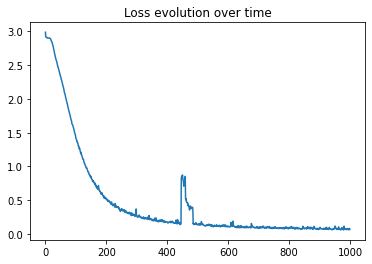

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss evolution over time')

In [17]:
filename = "model_weights_saved.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
# import keras
# m1 = keras.models.load_model('model_weights_saved.hdf5')
# m1.summary()

In [19]:
num_to_char = dict((i, c) for i, c in enumerate(chars))
''.join([num_to_char[element] for element in x_data[numpy.random.randint(0, len(x_data) - 1)]])

'mbiente pasiones chismes figures graves ridículas pasan realidad manos arte exactitud pasmosa reprod'

In [33]:
for x in range(10):
    start = numpy.random.randint(0, len(x_data) - 1)
    pattern = x_data[start]
    print("Random Seed:")
    print("\"", ''.join([num_to_char[value] for value in pattern]), "\"")

Random Seed:
" rsonas rincones catedral casino ambiente pasiones chismes figures graves ridículas pasan realidad ma "
Random Seed:
"  graves ridículas pasan realidad manos arte exactitud pasmosa reproducen mente lector acaba creerse  "
Random Seed:
" os vicios incapaces vida seria eficaz estiman mujeres formulismo religioso medio seguro reblandecer  "
Random Seed:
" adándonos mundo realidad tan malos ficción valemos aquí véase cristiano hábito pasar fácilmente mejo "
Random Seed:
" reten días menos largos aparición desgracia obra poética narrativa alcance longevidad siquiera decor "
Random Seed:
" umados abrumadores ley fatal engañada idealidad mística acierta encerrar verdaderos términos víctima "
Random Seed:
" los aunque pertinente asunto prólogo principal materia basta dicho entremos _la regenta_ admirar enc "
Random Seed:
"  propio tiempo feliz aleación bromas veras fundidas juntas crisol lengua semejante expresión equívoc "
Random Seed:
" ulpa prensa pueda ser modo mientras nuevo

In [20]:
start = numpy.random.randint(0, len(x_data) - 1)
pattern = x_data[start]
input_text = ''.join([num_to_char[value] for value in pattern])
generated_text = list()


print("Input Text: ", input_text)
for i in range(10):
    print(" Last chars from Input Pattern and prediction ---> ", ''.join([num_to_char[value] for value in pattern])[:20])
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = num_to_char[index]
    generated_text.append(result)
    print(" Prediction --->", result)
    print(" ")
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

Input Text:  rar verdaderos términos víctima fin propia imaginación sensibilidad contenida ve envuelta horrorosa 
 Last chars from Input Pattern and prediction --->  rar verdaderos térmi
 Prediction ---> c
 
 Last chars from Input Pattern and prediction --->  ar verdaderos términ
 Prediction ---> a
 
 Last chars from Input Pattern and prediction --->  r verdaderos término
 Prediction ---> t
 
 Last chars from Input Pattern and prediction --->   verdaderos términos
 Prediction ---> á
 
 Last chars from Input Pattern and prediction --->  verdaderos términos 
 Prediction ---> s
 
 Last chars from Input Pattern and prediction --->  erdaderos términos v
 Prediction ---> t
 
 Last chars from Input Pattern and prediction --->  rdaderos términos ví
 Prediction ---> r
 
 Last chars from Input Pattern and prediction --->  daderos términos víc
 Prediction ---> o
 
 Last chars from Input Pattern and prediction --->  aderos términos víct
 Prediction ---> f
 
 Last chars from Input Pattern and predi

In [21]:
start = numpy.random.randint(0, len(x_data) - 1)
pattern = x_data[start]
input_text = ''.join([num_to_char[value] for value in pattern])
generated_text = list()



for i in range(200):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = num_to_char[index]
    generated_text.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [22]:
print("Input Text: ", input_text)
generated_text = ''.join([value for value in generated_text])
print("Generated Text --->", generated_text)

Input Text:  a escritores d juan valera saben poner hondas disertaciones cosa mística ascética corroborar dicho n
Generated Text ---> ingún ejemplo mejor _la regenta_ muestra feliz naturalismo restaurado reintegrado calidad ser origen empresa _clarín_ fácil realizar sentirlo dejándose llevar impulsos primordiales grande ingenio infl


# Results understanding 

Let us find where does a part of the input text appears on the training text and check what is coming after.
Firstly, we will check the differences with the input text used for the model,
which of course will be the presence of the stop words.

In [113]:
input_text[7:]

'simbólico historia raza verá lector _clarín_ obligado asunto escoger dos males decide mal seg'

In [116]:
i = text.index('simbólico')
text[i:i+450]

'simbólico con la historia de nuestra raza. Verá también el lector que _Clarín_, obligado en el asunto a escoger entre dos males, se decide por el mal seglar, que siempre es menos odioso que el mal eclesiástico, pues tratándose de dar la presa a uno de los dos diablos que se la disputan, natural es que sea postergado el que se vistió de sotana para sus audaces tentaciones, ultrajando con su vestimenta el sacro dogma y la dignidad sacerdotal. Dejan'

In [114]:
generated_text

'lar siempre menos odioso mal eclesiástico pues tratándose dar presa dos diablos disputan natural postergado vistió sotana audaces tentaciones ultrajando vestimenta sacro dogma dignidad sacerdotal deja'

As we can see, it generates the **same text** as we have used as input text. This might be a case of overfitting. In my opinion, these results are bad
because this is not the expected behaviour, always to generate same or similar text. 

Also for me there is no point in cleaning stopwords because the generated and the input text loses all the sense to the human understanding. I had more results and conclussions extracted for text without stopwords but as I have explained for me and at least for the moment it makes no sense to analyze these kind of results.
Specially when dealing with languages like spanish where the stop words contribute to the sense of the sentence. In my opinion, these stop words should only be removed on problems like sentence clasification (and not all, often the negations are crucial). 

It is too hard to evaluate results if we are filtering the stopwords. Let us train using the stopwords.

## Retraining with Stopwords

In [7]:
def tokenize_words(input):
    input = input.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input)
    return ' '.join([value for value in tokens])

In [13]:
processed_inputs = tokenize_words(text)
chars = sorted(list(set(processed_inputs)))
char_to_num = dict((c, i) for i, c in enumerate(chars))
input_len = len(processed_inputs)
vocab_len = len(chars)
print ("Total number of characters:", input_len)
print ("Total vocab:", vocab_len)

seq_length = 100
x_data = []
y_data = []

for i in range(0, input_len - seq_length, 1):
    in_seq = processed_inputs[i:i + seq_length]
    out_seq = processed_inputs[i + seq_length]
    x_data.append([char_to_num[char] for char in in_seq])
    y_data.append(char_to_num[out_seq])

n_patterns = len(x_data)
print ("Total Patterns:", n_patterns)

X = numpy.reshape(x_data, (n_patterns, seq_length, 1))
X = X/float(vocab_len)

y = np_utils.to_categorical(y_data)


Total number of characters: 19003
Total vocab: 34
Total Patterns: 18903


In [95]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath = "model_weights_saved_with_sw.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

model.fit(X, y, epochs=1000, batch_size=256, callbacks=desired_callbacks)

Total number of characters: 19003
Total vocab: 34
Total Patterns: 18903
Epoch 1/1000
74/74 [==============================] - 24s 157ms/step - loss: 3.0196

Epoch 00001: loss improved from inf to 2.91551, saving model to model_weights_saved_with_sw.hdf5
Epoch 2/1000
74/74 [==============================] - 11s 155ms/step - loss: 2.8578

Epoch 00002: loss improved from 2.91551 to 2.85749, saving model to model_weights_saved_with_sw.hdf5
Epoch 3/1000
74/74 [==============================] - 12s 156ms/step - loss: 2.8533

Epoch 00003: loss improved from 2.85749 to 2.85232, saving model to model_weights_saved_with_sw.hdf5
Epoch 4/1000
74/74 [==============================] - 12s 156ms/step - loss: 2.8494

Epoch 00004: loss improved from 2.85232 to 2.84822, saving model to model_weights_saved_with_sw.hdf5
Epoch 5/1000
74/74 [==============================] - 12s 156ms/step - loss: 2.8507

Epoch 00005: loss improved from 2.84822 to 2.84689, saving model to model_weights_saved_with_sw.hdf5
Ep

In [5]:
print("Now, let us evaluate the results ")
print("Let us load the model")

Now, let us evaluate the results 
Let us load the model


### Model and weights loading

In [14]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

filename = "model_weights_saved_with_sw.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [49]:
def return_generated(i_text:str, generated_text_length: int = 200) -> str:
  processed_inputs = tokenize_words(i_text)
  seq_length = 100
  input_len = len(processed_inputs)
  nx_data = []
  ny_data = []
  for i in range(0, input_len - seq_length, 1):
    in_seq = processed_inputs[i:i + seq_length]
    out_seq = processed_inputs[i + seq_length]
    nx_data.append([char_to_num[char] for char in in_seq])
    ny_data.append(char_to_num[out_seq])
  start = numpy.random.randint(0, len(nx_data) - 1)
  pattern = nx_data[start]
  input_text = ''.join([num_to_char[value] for value in pattern])
  generated_text = list()
  for i in range(generated_text_length):
      x = numpy.reshape(pattern, (1, len(pattern), 1))
      x = x / float(vocab_len)
      prediction = model.predict(x, verbose=0)
      index = numpy.argmax(prediction)
      result = num_to_char[index]
      generated_text.append(result)
      pattern.append(index)
      pattern = pattern[1:len(pattern)]
  return ''.join([value for value in generated_text]) 

In [20]:
num_to_char = dict((i, c) for i, c in enumerate(chars))

In [59]:
w = text.index("Wieland")
t_i = text[w:w+400]


print(f"Input text 0 --> {t_i}", sep = ",")
print(" ")
print(f" Generated text 0 ---> {return_generated(t_i)}")

Input text 0 --> Wieland quien dijo _que los pensamientos de los hombres valen más que sus acciones, y las buenas novelas más que el género humano_. Podrá esto no ser verdad; pero es hermoso y consolador. Ciertamente, parece que nos ennoblecemos trasladándonos de este mundo al otro, de la realidad en que somos tan malos a la ficción en que valemos más que aquí, y véase por qué, cuando un cristiano el hábito de pas
 
 Generated text 0 --->  qué cuando un cristiano el hábito de pasar fácilmente a mejor vida inventando personas y tejiendo sucesos a imagen de los de por acá le cuesta no poco trabajo volver a este mundo también digo que si 


In [60]:
t_i = """Emma era el jefe de la familia; era más, según ya se ha dicho, su
tirano. Tíos, primos y sobrinos acataban sus órdenes, respetaban sus
caprichos. Este dominio sobre las almas no se explicaba de modo
suficiente por motivos económicos, pero sin duda estos influían
bastante. Todos los Valcárcel eran pobres. La fecundidad de la raza era
famosa en la provincia; las hembras de los Valcárcel parían mucho, y no
les iban en zaga las que los varones hacían ingresar en la familia,
mediante legítimo matrimonio. Procrear mucho y no querer trabajar, este
parecía ser el lema de aquella estirpe. Entre todos los Valcárcel no
había habido más hombre trabajador en todo el siglo que el padre de
Emma, el abogado, que también había sido, dentro del matrimonio, menos"""

print(f"Input text 1 --> {t_i}", sep = ",")
print(" ")
print(f" Generated text 1 ---> {return_generated(t_i)}")

Input text 1 --> Emma era el jefe de la familia; era más, según ya se ha dicho, su
tirano. Tíos, primos y sobrinos acataban sus órdenes, respetaban sus
caprichos. Este dominio sobre las almas no se explicaba de modo
suficiente por motivos económicos, pero sin duda estos influían
bastante. Todos los Valcárcel eran pobres. La fecundidad de la raza era
famosa en la provincia; las hembras de los Valcárcel parían mucho, y no
les iban en zaga las que los varones hacían ingresar en la familia,
mediante legítimo matrimonio. Procrear mucho y no querer trabajar, este
parecía ser el lema de aquella estirpe. Entre todos los Valcárcel no
había habido más hombre trabajador en todo el siglo que el padre de
Emma, el abogado, que también había sido, dentro del matrimonio, menos
 
 Generated text 1 ---> so seciendas los que leyeron _la regenta_ cuando se publicó léanla de nuevo ahora los que la desconocen hagan con ella conocimiento y unos y otros verán que nunca ha tenido este libro atmósfera de opo


In [61]:
t_i = """La verdad es que la noche era preciosa. A pesar de hacer mucho calor, las estrellas se observaban
perfectamente. Emma estaba emocianada y extasiada ante tamaña belleza. No se podía imaginar que simplemente
mirar al cielo y respirar profundamente pudiera relajar tanto. Por primera vez en muchos meses se sintió
tranquila y feliz"""

print(f"Input text 2 --> {t_i}", sep = ",")
print(" ")
print(f" Generated text 2 ---> {return_generated(t_i)}")

Input text 2 --> La verdad es que la noche era preciosa. A pesar de hacer mucho calor, las estrellas se observaban
perfectamente. Emma estaba emocianada y extasiada ante tamaña belleza. No se podía imaginar que simplemente
mirar al cielo y respirar profundamente pudiera relajar tanto. Por primera vez en muchos meses se sintió
tranquila y feliz
 
 Generated text 2 ---> la artiedad nerarta de su grande ingenio influido intensamente por la irresistible fuerza de opinión literaria en favor de la sinceridad narrativa y descriptiva admitió estas ideas con entusiasmo y la


In [62]:
t_i = """A pesar de ser una persona que había vivido numerosas situaciones complicadas en su vida, su optimismo le había ayudado mucho
haciéndole salir airoso de todas ellas. Se consideraba una persona afortunada y calmada, y así vivió el resto de años de su vida."""

print(f"Input text 3 --> {t_i}", sep = ",")
print(" ")
print(f" Generated text 3 ---> {return_generated(t_i)}")

Input text 3 --> A pesar de ser una persona que había vivido numerosas situaciones complicadas en su vida, su optimismo le había ayudado mucho
haciéndole salir airoso de todas ellas. Se consideraba una persona afortunada y calmada, y así vivió el resto de años de su vida.
 
 Generated text 3 ---> monan la degeria don lus de por acá le cuesta no poco trabajo volver a este mundo también digo que si grata es la tarea de fabricar género humano recreándonos en ver cuánto superan las ideales figuril


In [63]:
t_i = """Ahora tengo que utilizar como texto de entrada un estilo que piense que a priori no tendrá mucho que ver con el del escritor empleado hasta ahora. Es díficil tener
sensibilidad de qué sí y qué no va a tener sentido para el modelo"""

print(f"Input text 4 --> {t_i}", sep = ",")
print(" ")
print(f" Generated text 4 ---> {return_generated(t_i)}")

Input text 4 --> Ahora tengo que utilizar como texto de entrada un estilo que piense que a priori no tendrá mucho que ver con el del escritor empleado hasta ahora. Es díficil tener
sensibilidad de qué sí y qué no va a tener sentido para el modelo
 
 Generated text 4 ---> ra no podaresces rego timuemos en mabiendo que del punolo qiempo y con la sociedad en que vivimos persuadidos de que uno y otra no son tan malos como vulgarmente se cree y se dice y de que no mejorará


In [96]:
22

22